In [69]:
import pandas as pd
from matplotlib import pyplot
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statistics
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
pwd()

'/Users/julia/Desktop'

In [3]:
df = pd.read_csv('mapped.csv')

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (2,3,5,9,11,13,14,15,16,35,45) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.tail()

,Unnamed: 0,Fiscal Period Code,Project Number,Project Id,Project Name,Health and Safety Status,project_date_create,Project Status,SalesCloudClientNo,Related Opportunity Project Number,...,bookings_jtd,interest_current,interest_jtd,interest_ytd,multiplier_budget,multiplier_current,multiplier_target,overhead_current,overhead_rate,revenue_type
2179041,2179041,202103,30085660,3.00004e+14,BKK Additional Phase 1 Design Services,Plan Required,NaN,New - Pending Approval,NaN,30078666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2179042,2179042,202103,30085661,3.00004e+14,City of Baltimore 1267E TO 2 Water Design & En...,Plan Required,NaN,New,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2179043,2179043,202103,99999997,NaN,Water NT CI,Plan Required,NaN,On Hold - Inactive,NaN,Unspecified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2179044,2179044,202103,99999998,NaN,Caribe-Environment Booking Project,Plan Required,NaN,On Hold - Inactive,NaN,Unspecified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2179045,2179045,202103,99999999,NaN,Canada Plugs,Plan Required,NaN,On Hold - Inactive,NaN,Unspecified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179046 entries, 0 to 2179045
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   Fiscal Period Code                   int64  
 1   Project Number                       object 
 2   Project Id                           object 
 3   Project Name                         object 
 4   Health and Safety Status             object 
 5   project_date_create                  float64
 6   Project Status                       object 
 7   SalesCloudClientNo                   float64
 8   Related Opportunity Project Number   object 
 9   Contract Type Name                   object 
 10  Ultimate Customer AUS Market Sector  object 
 11  Division Short Name                  object 
 12  location_2                           object 
 13  location_4                           object 
 14  primary_client_industry              object 
 15  Sales Cloud Opportunity Number  

In [5]:
df['Project Number'] = df['Project Number'].astype('str') 
df['Fiscal Period Code'] = pd.to_datetime(df['Fiscal Period Code'], format='%Y%m') 

In [6]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [7]:
freq=df.groupby('Project Number')
count =freq['Project Number'].count()
df_count=pd.DataFrame({'Project Number':count.index, 'count':count.values})
df_count.sort_values('count', 
                      inplace=True, 
                      ascending=False)
df_count

,Project Number,count
81382,nan,1306653
6902,30004018,27
7248,30004364,27
7224,30004340,27
7221,30004337,27
...,...,...
41599,30082322,1
41598,30082321,1
41597,30082320,1
41596,30082319,1


In [24]:
df = pd.merge(df, df_count, on='Project Number')

In [25]:
df_27 = df[df['count'] == 27]

In [14]:
#Generate singel plot for Backlog given Project number
def revenue_analysis(project):
    df_project = df[df['Project Number'] == project]
    df_project = df_project[["Fiscal Period Code", "Funding Amount - ITC (Snapshot)", "Backlog NR", 'Actual Gross Revenue - ITD', 'Actual Gross Revenue - MTD','Actual Gross Revenue - YTD', 'Actual Net Revenue - ITD','Actual Net Revenue - MTD', 'Actual Net Revenue - YTD']].copy()
    df_project['Backlog_Shifted'] = df_project['Backlog NR'].transform(lambda x:x.shift())
    df_project.reset_index(inplace=True)
    df_project = df_project.loc[:, ~df_project.columns.str.contains('^index')]
    subset= df_project[['Fiscal Period Code', 'Actual Net Revenue - MTD']].copy()
    subset.plot(y ='Actual Net Revenue - MTD', x="Fiscal Period Code", kind="line")
    return pyplot.show()

In [11]:
#Generate dataframe based on project id
def obtain_df(project):
    df_project = df[df['Project Number'] == project]
    df_project = df_project[["Fiscal Period Code", "Funding Amount - ITC (Snapshot)", "Backlog NR", 'Actual Gross Revenue - ITD', 'Actual Gross Revenue - MTD','Actual Gross Revenue - YTD', 'Actual Net Revenue - ITD','Actual Net Revenue - MTD', 'Actual Net Revenue - YTD']].copy()
    df_project['Backlog_Shifted'] = df_project['Backlog NR'].transform(lambda x:x.shift())
    df_project.reset_index(inplace=True)
    df_project = df_project.loc[:, ~df_project.columns.str.contains('^index')]
    return df_project

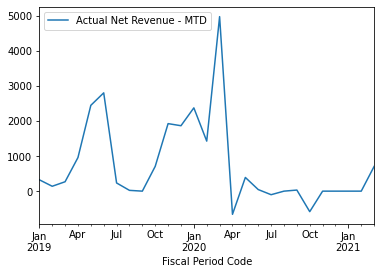

In [15]:
revenue_analysis('30004018') #30004340 #30004337

In [70]:
df_30004018 = obtain_df('30004018')

In [73]:
#Generate plot analysis 
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

def decomposition_plot(project_number, name, sector):
    df_pn= df[df['Project Number'] == project_number]
    df_pn = df_pn[['Fiscal Period Code', 'Actual Net Revenue - MTD']].copy()
    df_pn = df_pn.set_index('Fiscal Period Code')
    decomposition = sm.tsa.seasonal_decompose(df_pn, model='additive')
    fig = decomposition.plot()
    return print(f" Selected Project Number: {project_number}"), print(f" Name: {name}"), print(f" Sector: {sector}"), plt.show()

In [100]:
#Extracting random samples from the dataframe with 27 observations
def random_project():
    df_x = df_27.sample(n=1)
    project_number = df_x['Project Number'].item()
    return project_number

In [101]:
random_project()

'30015014'

In [102]:
def random_project_analysis():
    df_x = df_27.sample(n=1)
    project_number = df_x['Project Number'].item()
    name = df_x['Project Name'].item()
    sector = df_x['Ultimate Customer AUS Market Sector'].item()
    return decomposition_plot(project_number, name, sector)

 Selected Project Number: 30006041
 Name: CG283004.0000-DWM 2020 Program Management
 Sector: Municipalities/Local Govt.


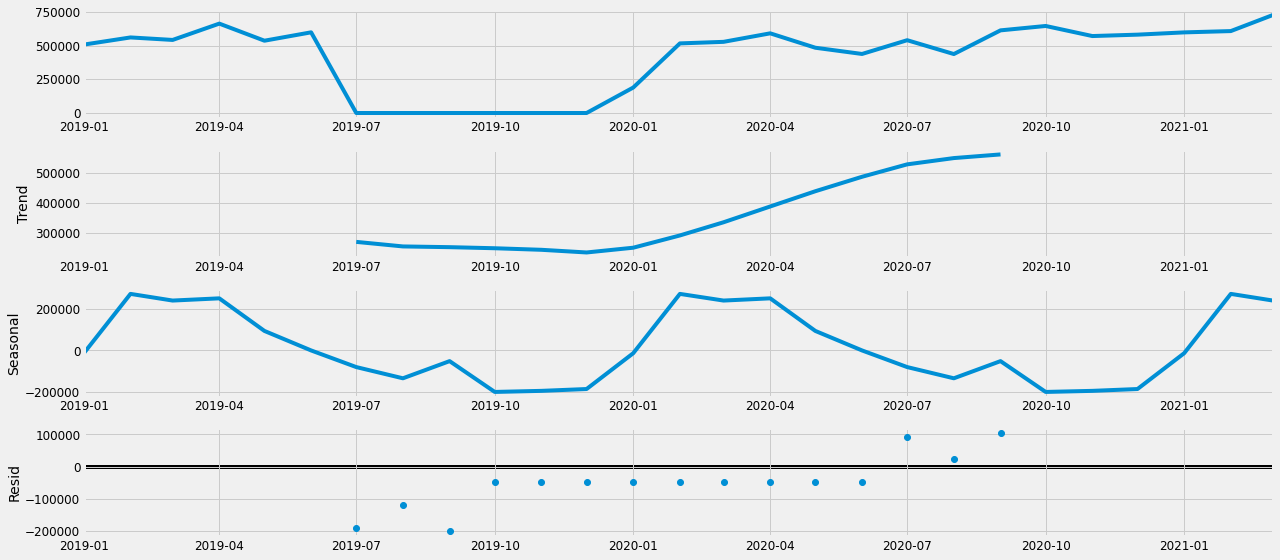

(None, None, None, None)

In [104]:
random_project_analysis()

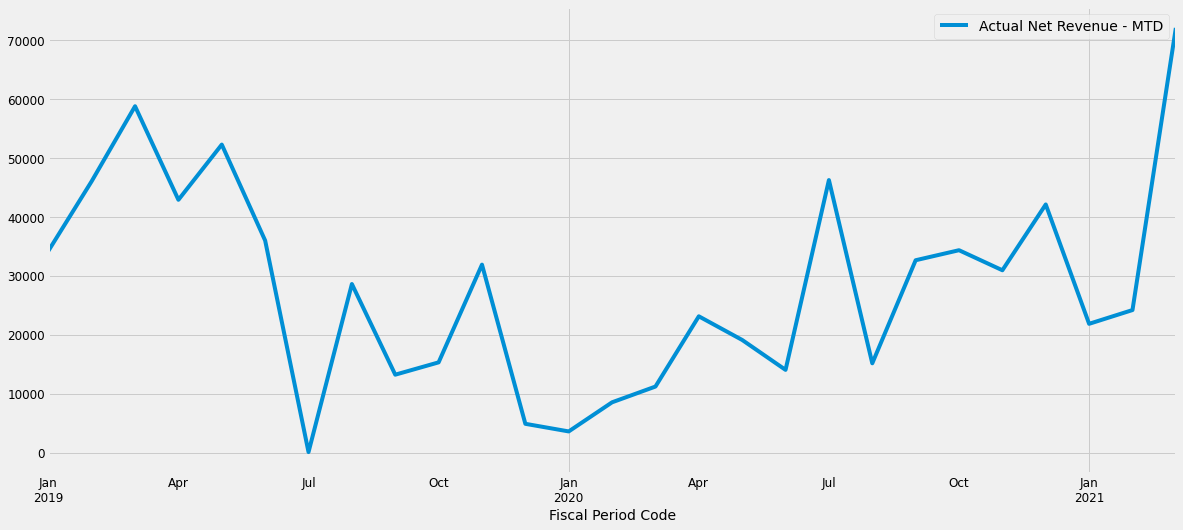

In [117]:
revenue_analysis('30001972')

### Time Series using ARIMA
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data

In [82]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [88]:
def obtain_timeseries(project):
    df_pn = obtain_df(project)
    df_pn = df_pn[['Fiscal Period Code', 'Actual Net Revenue - MTD']].copy()
    df_pn = df_pn.set_index('Fiscal Period Code')
    return df_pn

In [115]:
x=random_project()
x

'30001972'

In [120]:
some_df =obtain_timeseries('30013631') #'30013631' df_30013631

In [121]:
# This is simulating a grid search for the most optimal parameters? 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(some_df, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:443.39376691848776
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:244.3516077441288
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:247.70547958537995
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:35.07517861433414
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:263.7587684089031
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:246.29635935384553
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:47.648411085561165
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:33.96367062087425
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:424.6760236758958
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:225.9776564173631
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:224.97742416638647
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:19.75230693600973
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:260.73237221882914
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:222.66542428825804
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:46.70882748140007
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1.8275994430903397
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:427.3797322980675
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:228.21645127007568
A

In [ ]:
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:0.9472134577695943
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:-0.17413328042899856

In [123]:
#Fit the model with the best parameters
mod = sm.tsa.statespace.SARIMAX(some_df,
                                order=(1, 0, 0),
                                seasonal_order=(1, 1, 0, 12),
                                #enforce_stationarity=False,
                                enforce_invertibility=False) 
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6056      0.421      1.440      0.150      -0.219       1.430
ar.S.L12      -0.8649      0.343     -2.519      0.012      -1.538      -0.192
sigma2      9.653e+05   1.19e+06      0.810      0.418   -1.37e+06     3.3e+06


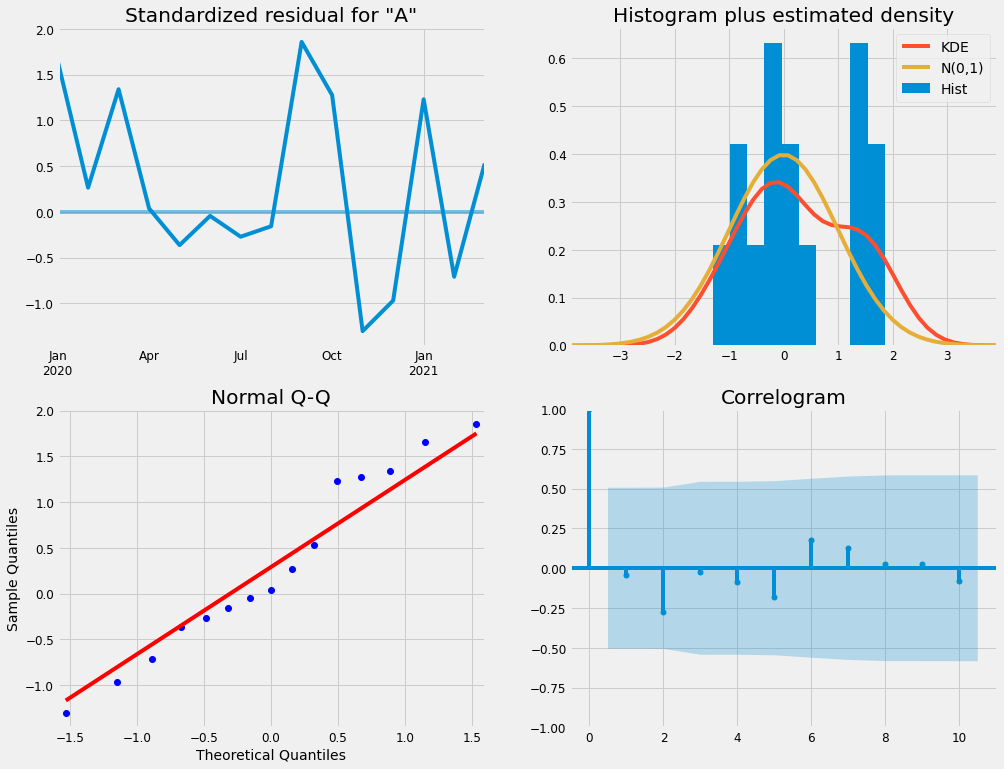

In [124]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

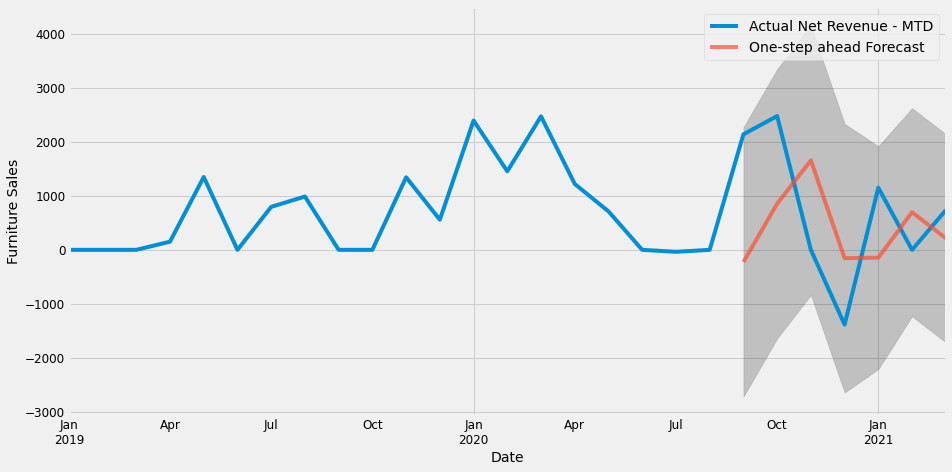

In [128]:
pred = results.get_prediction(start=pd.to_datetime('2020-09'), dynamic=False)
pred_ci = pred.conf_int()
ax = some_df['2019-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [147]:
y_forecasted = pred.predicted_mean
y_truth = some_df['2020-09':]
y_truth = pd.Series(y_truth['Actual Net Revenue - MTD'].values, index=y_truth.index)
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2125769.04


In [148]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 1458.0
